# 기본 LSTM 모델 
LSTM을 제대로 활용하기 위해서는 상태유지 모드, 배치사이즈, 타임스텝, 속성에 대한 개념에 이해가 필요합니다
- 타임스텝이란 하나의 샘플에 포함된 시퀀스 개수입니다. 이는 앞서 살펴본 “input_length”와 동일합니다. 
- 윈도우 크기와 동일하게 타임스텝으로 설정하면 됩니다. 
- 설정한 LSTM 모델에 따라 입력할 데이터셋도 샘플 수, 타임스텝 수, 속성 수 형식으로 맞추어야 합니다. 

## 0. 사용할 패키지 불러오기 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
import numpy as np

### 0.1 랜덤시드 고정하기 
동일한 결과를 얻기 위해 시드를 고정한다.

In [2]:
np.random.seed(5)

### 0.2 손실 이력 클래스 정의

In [3]:
class LossHistory(Callback):
    def init(self):
        self.losses = []
    
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))  
        

## 1. 데이터셋 생성
### 1.1 코드 변환 사전
* code2idx : 코드를 숫자로 변환 
* idx2code : 숫자를 코드로 변환

In [4]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

### 1.2 데이터 셋 생성 함수 정의 
- 사전을 이용해서 순차적인 음표를 우리가 지정한 윈도우 크기만큼 잘라 데이터셋을 생성하는 함수를 정의

In [5]:
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

### 1.3 데이터 셋

In [6]:
# 시퀀스 데이터 정의 
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


### 1.4 데이터 준비 

#### 1.4.1 입력과 출력 변수로 분리 

In [7]:
x_train = dataset[:, 0:4]
y_train = dataset[:, 4]
max_idx_value = 13
print(x_train)
print(y_train)

[[11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  8]
 [ 1  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]
 [ 9 10 11 11]
 [10 11 11  4]
 [11 11  4 11]
 [11  4 11  9]
 [ 4 11  9  9]
 [11  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  8]
 [ 9 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]
 [11  9  9  2]
 [ 9  9  2  8]
 [ 9  2  8  8]
 [ 2  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  9]
 [ 8  8  9  3]
 [ 8  9  3  9]
 [ 9  3  9  9]
 [ 3  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  4]
 [ 9 10  4 11]
 [10  4 11  9]
 [ 4 11  9  2]
 [11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]]
[ 8  1  7  8  9 10 11 11  4 11  9  9  9 10  8  1  7  9 11 11  9  9  2  8
  8  8  8  8  9  3  9  9  9  9  9 10  4 11  9  2 10  8  1  7  9 11 11  9
  9  2]


#### 1.4.2 입력값 정규화 시키기

In [8]:
x_train = x_train / float(max_idx_value)
print(x_train)

[[0.84615385 0.69230769 0.15384615 0.76923077]
 [0.69230769 0.15384615 0.76923077 0.61538462]
 [0.15384615 0.76923077 0.61538462 0.07692308]
 [0.76923077 0.61538462 0.07692308 0.53846154]
 [0.61538462 0.07692308 0.53846154 0.61538462]
 [0.07692308 0.53846154 0.61538462 0.69230769]
 [0.53846154 0.61538462 0.69230769 0.76923077]
 [0.61538462 0.69230769 0.76923077 0.84615385]
 [0.69230769 0.76923077 0.84615385 0.84615385]
 [0.76923077 0.84615385 0.84615385 0.30769231]
 [0.84615385 0.84615385 0.30769231 0.84615385]
 [0.84615385 0.30769231 0.84615385 0.69230769]
 [0.30769231 0.84615385 0.69230769 0.69230769]
 [0.84615385 0.69230769 0.69230769 0.69230769]
 [0.69230769 0.69230769 0.69230769 0.76923077]
 [0.69230769 0.69230769 0.76923077 0.61538462]
 [0.69230769 0.76923077 0.61538462 0.07692308]
 [0.76923077 0.61538462 0.07692308 0.53846154]
 [0.61538462 0.07692308 0.53846154 0.69230769]
 [0.07692308 0.53846154 0.69230769 0.84615385]
 [0.53846154 0.69230769 0.84615385 0.84615385]
 [0.69230769 

#### 1.4.3 라벨값에 대한 one-hot 인코딩 수행 

In [9]:
y_train = to_categorical(y_train)
print(y_train)    # 원-핫-인코딩 
one_hot_vec_size = y_train.shape[1]
print("one hot encoding vector size is ", one_hot_vec_size)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

## 2. 학습 과정 
학습시키는 방식 
- 파란색 박스가 입력값이고, 빨간색 박스가 우리가 원하는 출력값입니다.
- 1~4번째 음표를 데이터로 5번째 음표를 라벨값으로 학습을 시킵니다.
- 다음에는 2~5번째 음표를 데이터로 6번째 음표를 라벨값으로 학습을 시킵니다.
- 이후 한 음표씩 넘어가면서 노래 끝까지 학습시킵니다.

## 3 예측 과정 
### 3.1 한 스탭 예측 
한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 것을 반복하는 것입니다. 이 방법에서는 모델의 입력값으로는 항상 실제 음표가 들어갑니다.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 모델에 t1, t2, t3, t4를 입력하면 y1 출력이 나옵니다.
- 모델에 t2, t3, t4, t5를 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

### 3.2 곡 전체 예측
곡 전체 예측이란 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것입니다. 초반부가 지나면, 예측값만으로 모델에 입력되어 다음 예측값이 나오는 식입니다. 그야말로 “나비야~ 나”까지 알려주면 나머지까지 모두 연주를 하는 것이죠. 만약 중간에 틀린 부분이 생긴다면, 이후 음정, 박자는 모두 이상하게 될 가능성이 많습니다. 예측 오류가 누적되는 것이겠죠.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 예측값인 y0를 t4라고 가정하고, 모델에 t1, t2, t3, t4을 입력하면 y1 출력이 나옵니다.
- 예측값인 y1을 t5라고 가정하고, 모델에 t2, t3, t4(예측값), t5(예측값)을 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

## 4 다층 퍼셉트론 신경망 모델 
앞서 생성한 데이터셋으로 먼저 다층 퍼셉트론 모델을 학습시켜보겠습니다. Dense 레이어 3개로 구성하였고, 입력 속성이 4개이고 출력이 12개(one_hot_vec_size=12)으로 설정했습니다.

### 4.1 모델 생성하기
모델 구성 
- 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
- 입력은 샘플이 50개, 타임스텝이 4개, 속성이 1개로 구성
- 상태유지(stateful) 모드 비활성화
- 인자로 “input_shape = (4, 1)’과 “input_dim = 1, input_length = 4”는 동일합니다.

In [10]:
model = Sequential()
model.add(LSTM(128, input_shape =(4,1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))
model.summary()

NameError: name 'LSTM' is not defined

### 4.2 모델 구성 확인

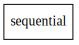

In [11]:
from IPython.display import SVG, display
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
import os

os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin"

%matplotlib inline

iv1_dot = model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=70)   # 사이즈 변경하기 
plot_model(model, to_file='model.png')
display(SVG(iv1_dot.create(prog=['dot'], format='svg')))

## 5 모델 학습과정 설정 

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = LossHistory() # 손실 이력 객체 생성
history.init()

## 6 모델 학습시키기

In [13]:
hist = model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])

Epoch 1/2000


ValueError: in user code:

    C:\python\37\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    C:\python\37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\keras\engine\training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\python\37\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\python\37\lib\site-packages\tensorflow\python\keras\losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    C:\python\37\lib\site-packages\tensorflow\python\keras\losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\keras\losses.py:1527 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\python\37\lib\site-packages\tensorflow\python\keras\backend.py:4561 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\python\37\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1117 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (10, 12) and (10, 4) are incompatible


## 7 학습과정 살펴보기

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train'], loc='upper left')

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

NameError: name 'hist' is not defined

## 8 모델 평가하기

In [15]:
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

ValueError: in user code:

    C:\python\37\lib\site-packages\tensorflow\python\keras\engine\training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    C:\python\37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\keras\engine\training.py:912 test_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\python\37\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\python\37\lib\site-packages\tensorflow\python\keras\losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    C:\python\37\lib\site-packages\tensorflow\python\keras\losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    C:\python\37\lib\site-packages\tensorflow\python\keras\losses.py:1527 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\python\37\lib\site-packages\tensorflow\python\keras\backend.py:4561 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\python\37\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1117 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 12) and (None, 4) are incompatible


## 9 모델 사용 하기 

In [16]:
pred_count = 50 # 최대 예측 개수 정의

### 9.1 한 스탭 예측 

In [17]:
seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i])     # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx])    # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'c4', 'e4', 'd4', 'c4', 'c4', 'f4', 'f4', 'f4', 'e4', 'd4', 'c4', 'c4', 'd4', 'c4', 'f4', 'e4', 'd4', 'c4', 'f4', 'f4', 'e4', 'd4', 'c4', 'c4', 'c4', 'c4', 'd4', 'c4', 'c4', 'f4', 'e4', 'd4', 'c4', 'd4', 'c4', 'c4', 'f4', 'e4', 'f4', 'e4', 'd4', 'c4', 'e4', 'd4', 'c4', 'f4', 'f4', 'e4', 'd4', 'c4']


### 9.2 곡 전체 예측 

In [18]:
seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in]    # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

full song prediction :  ['g8', 'e8', 'e4', 'f8', 'c4', 'e4', 'd4', 'c4', 'd4', 'c4', 'c4', 'd4', 'c4', 'e4', 'f4', 'f4', 'e4', 'd4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4', 'c4']
